##Analyse hsa-miR-124a-3p transfection time-course 

In order to do this analysis you have to be in the tests directory of GEOparse.

In the paper *Systematic identification of microRNA functions by combining target prediction and expression profiling* Wang and Wang provided a series of microarrays from 7 time-points after miR-124a transfection. The series can be found in GEO under the GSE6207 accession. We use this series to demonstrate general principles of GEOparse. Mind that this tutorial is not abut how to properly calculate log fold changes - the approach undertaken here is simplistic.

We start with the imports:

In [88]:
%matplotlib inline
import GEOparse
import pandas as pd
import pylab as pl
import seaborn as sns
pl.rcParams['figure.figsize'] = (14, 10)
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['xtick.labelsize'] = 11
pl.rcParams['axes.labelsize'] = 23
pl.rcParams['legend.fontsize'] = 20
sns.set_style('ticks')
c1, c2, c3, c4 = sns.color_palette("Set1", 4)

We also prepared a simple tabulated file with the description of each GSM. It will be usefull to calculate LFC.

In [91]:
experiments = pd.read_table("GSE6207_experiments.tab")

We can look in to this file:

In [90]:
experiments

,Experiment,Type,Time
0,GSM143385,transfection,4 hours
1,GSM143386,control,4 hours
2,GSM143387,transfection,8 hours
3,GSM143388,control,8 hours
4,GSM143389,transfection,16 hours
5,GSM143390,control,16 hours
6,GSM143391,transfection,24 hours
7,GSM143392,control,24 hours
8,GSM143393,transfection,32 hours
9,GSM143394,control,32 hours


Now we select the GSMs that are controls.

In [92]:
controls = experiments[experiments.Type == 'control'].Experiment.tolist()

Using GEOparse we can download experiments and look into the data:

In [93]:
gse = GEOparse.get_GEO("GSE6207")

File already exist: using local version.
Parsing ./GSE6207.soft.gz:
 - DATABASE : GeoMiame
 - SERIES : GSE6207
 - PLATFORM : GPL570
 - SAMPLE : GSM143385
 - SAMPLE : GSM143386
 - SAMPLE : GSM143387
 - SAMPLE : GSM143388
 - SAMPLE : GSM143389
 - SAMPLE : GSM143390
 - SAMPLE : GSM143391
 - SAMPLE : GSM143392
 - SAMPLE : GSM143393
 - SAMPLE : GSM143394
 - SAMPLE : GSM143395
 - SAMPLE : GSM143396
 - SAMPLE : GSM143397
 - SAMPLE : GSM143398


The GPL we are interested:

In [94]:
gse.gpls['GPL570'].columns

,description
ID,"Affymetrix Probe Set ID LINK_PRE:""https://www...."
GB_ACC,"GenBank Accession Number LINK_PRE:""http://www...."
SPOT_ID,identifies controls
Species Scientific Name,The genus and species of the organism represen...
Annotation Date,The date that the annotations for this probe a...
Sequence Type,
Sequence Source,The database from which the sequence used to d...
Target Description,
Representative Public ID,The accession number of a representative seque...
Gene Title,Title of Gene represented by the probe set.


And the columns that are available for exemplary GSM:

In [6]:
gse.gsms["GSM143385"].columns

,description
ID_REF,Affymetrix probe set ID
VALUE,RMA normalized Signal intensity (log2 transfor...


We take the opportunity and check if everything is OK with the control samples. For this we just use simple histogram. To obtain table with each GSM as column, ID_REF as index and VALUE in each cell we use pivot_samples method from GSE object (we restrict the columns to the controls):

In [97]:
pivoted_control_samples = gse.pivot_samples('VALUE')[controls]
pivoted_control_samples.head()

name,GSM143386,GSM143388,GSM143390,GSM143392,GSM143394,GSM143396,GSM143398
ID_REF,,,,,,,
1007_s_at,9.373339,9.316689,9.405605,9.332526,9.351024,9.245251,9.423234
1053_at,8.453839,8.440368,8.435023,8.411635,8.373939,8.082178,7.652785
117_at,5.878466,5.928938,5.969288,5.984232,5.882761,5.939399,6.027338
121_at,9.131430,9.298601,9.176132,9.249977,9.149849,9.250952,9.352397
1255_g_at,3.778179,3.861210,3.740103,3.798814,3.761673,3.790185,3.895462


And we plot:

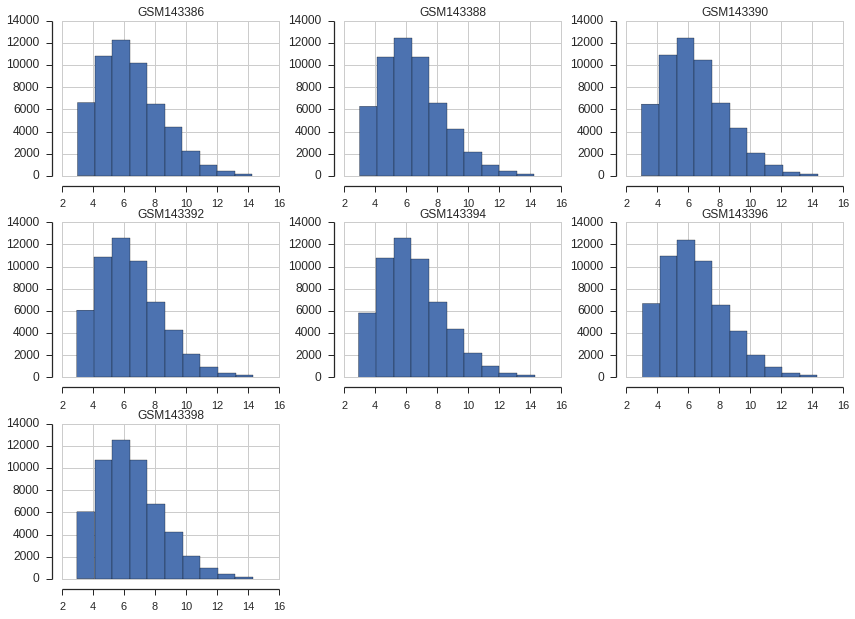

In [98]:
pivoted_control_samples.hist()
sns.despine(offset=10, trim=True)

Next we would like to filter out probes that are not expressed. The gene is expressed (in definition here) when its average log2 intensity in control samples is above 0.25 quantile. I.e. we filter out worst 25% genes.

In [99]:
pivoted_control_samples_average = pivoted_control_samples.median(axis=1)
print "Number of probes before filtering: ", len(pivoted_control_samples_average)

Number of probes before filtering:  54675


In [10]:
expression_threshold = pivoted_control_samples_average.quantile(0.25)

In [100]:
expressed_probes = pivoted_control_samples_average[pivoted_control_samples_average >= expression_threshold].index.tolist()
print "Number of probes above threshold: ", len(expressed_probes)

Number of probes above threshold:  41006


We can see that the filtering succeeded. Now we can pivot all the samples and filter out probes that are not expressed:

In [102]:
samples = gse.pivot_samples("VALUE").ix[expressed_probes]

The most important thing is to calculate log fold changes. What we have to do is for each time-point identify control and transfected sample and subtract the VALUES (they are provided as log2 transformed already, we subtract transfection from the control). In the end we create new DataFrame with LFCs: 

In [103]:
lfc_results = {}
sequence = ['4 hours',
             '8 hours',
             '16 hours',
             '24 hours',
             '32 hours',
             '72 hours',
             '120 hours']
for time, group in experiments.groupby("Time"):
    print time
    control_name = group[group.Type == "control"].Experiment.iloc[0]
    transfection_name = group[group.Type == "transfection"].Experiment.iloc[0]
    lfc_results[time] = (samples[transfection_name] - samples[control_name]).to_dict()
lfc_results = pd.DataFrame(lfc_results)[sequence]

120 hours
16 hours
24 hours
32 hours
4 hours
72 hours
8 hours


Let's look at the data sorted by 24-hours time-point:

In [104]:
lfc_results.sort("24 hours").head()

,4 hours,8 hours,16 hours,24 hours,32 hours,72 hours,120 hours
214149_s_at,0.695643,-0.951014,-1.768543,-3.326683,-2.954085,-3.121960,-1.235596
214835_s_at,-0.120661,-1.282502,-2.540301,-3.238786,-3.183429,-3.284111,-1.901547
212459_x_at,0.010564,-1.092724,-2.235531,-3.203148,-3.115878,-3.008434,-1.706501
201171_at,0.958699,-1.757044,-1.571311,-3.173688,-3.061849,-2.672462,-1.456556
215446_s_at,-0.086179,-0.408025,-1.550514,-3.083213,-3.024972,-4.374527,-2.581921


We are interested in the gene expression changes upon transfection. Thus, we have to annotate each probe with ENTREZ gene ID, remove probes without ENTREZ or with multiple assignments. Although this strategy might not be optimal, after this we average the LFC for each gene over probes.

In [105]:
# annotate with GPL
lfc_result_annotated = lfc_results.reset_index().merge(gse.gpls['GPL570'].table[["ID", "ENTREZ_GENE_ID"]],
                                left_on='index', right_on="ID").set_index('index')
del lfc_result_annotated["ID"]
# remove probes without ENTREZ
lfc_result_annotated = lfc_result_annotated.dropna(subset=["ENTREZ_GENE_ID"])
# remove probes with more than one gene assigned
lfc_result_annotated = lfc_result_annotated[~lfc_result_annotated.ENTREZ_GENE_ID.str.contains("///")]
# for each gene average LFC over probes
lfc_result_annotated = lfc_result_annotated.groupby("ENTREZ_GENE_ID").median()

We can now look at the data:

In [16]:
lfc_result_annotated.sort("24 hours").head()

,4 hours,8 hours,16 hours,24 hours,32 hours,72 hours,120 hours
ENTREZ_GENE_ID,,,,,,,
8801,-0.027313,-1.130051,-2.189180,-3.085749,-2.917788,-2.993609,-1.700850
8992,0.342758,-0.884020,-1.928357,-3.017827,-3.024406,-2.991851,-1.160622
9341,-0.178168,-0.591781,-1.708289,-2.743563,-2.873147,-2.839508,-1.091627
201965,-0.109980,-0.843801,-1.910224,-2.736311,-2.503068,-2.526326,-1.081906
84803,-0.051439,-0.780564,-1.979405,-2.513718,-3.123384,-2.506667,-1.035104


At that point our job is basicaly done. However, we might want to check if the experiments worked out at all. To do this we will use hsa-miR-124a-3p targets predicted by MIRZA-G algorithm. The targets should be downregulated. First we read MIRZA-G results:

In [108]:
header = ["GeneID", "miRNA", "Total score without conservation", "Total score with conservation"]
miR124_targets = pd.read_table("seed-mirza-g_all_mirnas_per_gene_scores_miR_124a.tab", names=header)
miR124_targets.head()

,GeneID,miRNA,Total score without conservation,Total score with conservation
0,55119,hsa-miR-124-3p,0.387844,0.691904
1,538,hsa-miR-124-3p,0.243814,0.387032
2,57602,hsa-miR-124-3p,0.128944,NaN
3,3267,hsa-miR-124-3p,0.405515,0.371705
4,55752,hsa-miR-124-3p,0.411628,0.373977


We shall extract targets as a simple list of strings:

In [109]:
miR124_targets_list = map(str, miR124_targets.GeneID.tolist())
print "Number of targets:", len(miR124_targets_list)

Number of targets: 2311


As can be seen there is a lot of targets (genes that posses a seed match in their 3'UTRs). We will use all of them. As first stem we will annotate genes if they are targets or not and add this information as a column to DataFrame:

In [85]:
lfc_result_annotated["Is miR-124a target"] = [i in miR124_targets_list for i in lfc_result_annotated.index]

In [86]:
cols_to_plot = [i for i in lfc_result_annotated.columns if "hour" in i]

In the end we can plot the results:

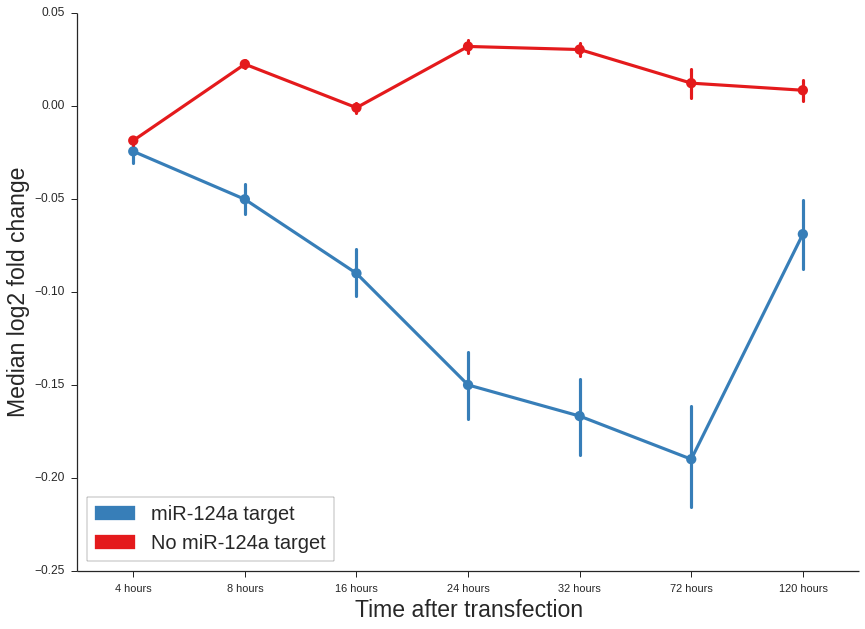

In [87]:
a = sns.pointplot(data=lfc_result_annotated[lfc_result_annotated["Is miR-124a target"]][cols_to_plot],
                   color=c2,
                   label="miR-124a target")
b = sns.pointplot(data=lfc_result_annotated[~lfc_result_annotated["Is miR-124a target"]][cols_to_plot],
             color=c1,
             label="No miR-124a target")
sns.despine()
pl.legend([pl.mpl.patches.Patch(color=c2), pl.mpl.patches.Patch(color=c1)],
          ["miR-124a target", "No miR-124a target"], frameon=True, loc='lower left')
pl.xlabel("Time after transfection")
pl.ylabel("Median log2 fold change")

As can be seen the targets of hsa-miR-124a-3p behaves in the expected way. With each time-point their downregulation is stronger up the 72 hours. After 120 hours the transfection is probably lost. This means that the experiments worked out.